In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
device = torch.device("cuda:0")
!gcc --version
# opencv is pre-installed on colab

1.5.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (colab has CUDA 10.1 + torch 1.5)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.5")
!pip install detectron2==0.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
download = drive.CreateFile({'id': '1E5kI8CLoC-XffqQMTWwSpBIPp1Wb2tne'})
download.GetContentFile('train.tar.7z')
download = drive.CreateFile({'id': '1Z6Qxr-q-F54iYB2G1AyoDymBh64f5REZ'})
download.GetContentFile('test.tar.7z')

In [ ]:
!7z x -so train.tar.7z | tar xf - -C ./
!7z x -so test.tar.7z | tar xf - -C ./

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!cp -r "/content/gdrive/My Drive/output" "/content/output" 

In [ ]:
from detectron2.structures import BoxMode
from os import walk


def dataset_train_dicts(path):
  data_dicts = []
  idx = 0
  mypath = '/content/Synthetic Train Set - Detection & Recognition/Annotation'
  for (dirpath, dirnames, filenames) in walk(mypath):
    
    if len(filenames)==0:
      continue 
      
    loc = dirpath.split('/');
    t='/'.join(loc[:-2])+'/Image/'+loc[-1]
    for i in filenames:
      record = {}
      # print(i,i[:-4])
      file_n=i[:-4]+'.jpg'
      
      filename = os.path.join(t,file_n)
      print(filename)
      img=cv2.imread(filename)
      # cv2_imshow(img)
      height, width = cv2.imread(filename).shape[:2]
      # print(height, width)
      record['file_name'] = filename
      record["image_id"] = idx
      record['height'] = height
      record['width'] = width
      idx+=1
      objs=[]

      with open(os.path.join(dirpath,i)) as f:
        lines = f.readlines()

      for line in lines:
        pos = line.split(' ')
        # print(pos)
        px=[float(j) for j in pos[:4]]
        py=[float(j) for j in pos[4:-1]]
        poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
        poly = [p for x in poly for p in x]

        obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
        objs.append(obj)
      record["annotations"] = objs
      data_dicts.append(record)
  print(data_dicts)
  return data_dicts  

In [ ]:
def dataset_test_dicts(path):
  data_dicts = []
  idx = 0
  mypath = '/content/real_Image_dataset_Detection/Annotation'
  for (dirpath, dirnames, filenames) in walk(mypath):
    
    if len(filenames)==0:
      continue 
    print(dirpath,dirnames, filenames)
    loc = dirpath.split('/');
    loc[-1]='Image'
    t='/'.join(loc)
    for i in filenames:
      record = {}
      # print(i,i[:-4])
      file_n=i[:-4]+'.jpg'
      
      filename = os.path.join(t,file_n)
      print(filename)
      img=cv2.imread(filename)
      # cv2_imshow(img)
      height, width = cv2.imread(filename).shape[:2]
      # print(height, width)
      record['file_name'] = filename
      record["image_id"] = idx
      record['height'] = height
      record['width'] = width
      idx+=1
      objs=[]

      with open(os.path.join(dirpath,i)) as f:
        lines = f.readlines()

      for line in lines:
        pos = line.split(',')
        # print(pos)
        px=[float(j) for j in pos[:4]]
        py=[float(j) for j in pos[4:-1]]
        poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
        poly = [p for x in poly for p in x]

        obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
        objs.append(obj)
      record["annotations"] = objs
      data_dicts.append(record)
  print(data_dicts)
  return data_dicts  

In [ ]:
train_dict = dataset_train_dicts('/content')

In [ ]:
print(len(train_dict))

116132


In [ ]:
test_dict = dataset_test_dicts('/content')

In [ ]:
print(len(test_dict))

428


In [ ]:
d='/content/Synthetic Train Set - Detection & Recognition/Annotation'
DatasetCatalog.register("text_train", lambda d=d: dataset_train_dicts(d))
MetadataCatalog.get("text_train").set(thing_classes=["text"])
d='/content/real_Image_dataset_Detection/Annotation'
DatasetCatalog.register("text_test", lambda d=d: dataset_test_dicts(d))
MetadataCatalog.get("text_test").set(thing_classes=["text"])

text_metadata = MetadataCatalog.get("text_train")

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("text_train",)
cfg.DATASETS.TEST = ("text_test")
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 3000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

/content/real_Image_dataset_Detection/Image/Pandit-Kulfi-1.jpg


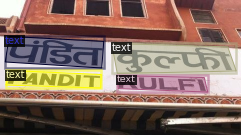

/content/real_Image_dataset_Detection/Image/11. nyoooz_hindi1902_1507879752.jpg


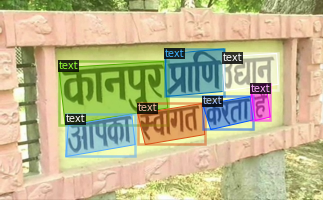

/content/real_Image_dataset_Detection/Image/panchavati-gaurav-to-add-50-outl-807e888a81.jpg


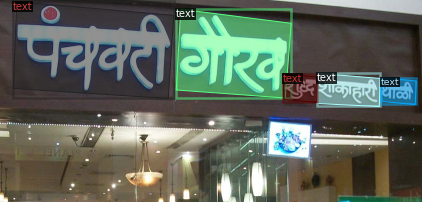

/content/real_Image_dataset_Detection/Image/193.jpg


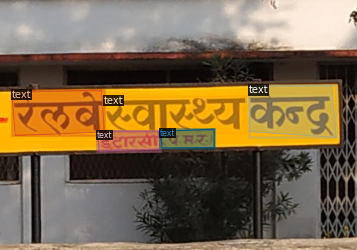

/content/real_Image_dataset_Detection/Image/108.jpg


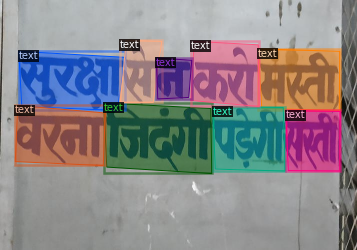

/content/real_Image_dataset_Detection/Image/238.jpg


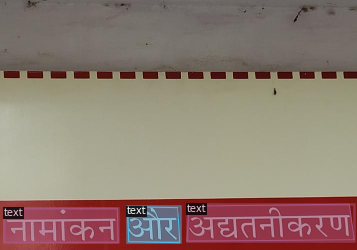

/content/real_Image_dataset_Detection/Image/123.jpg


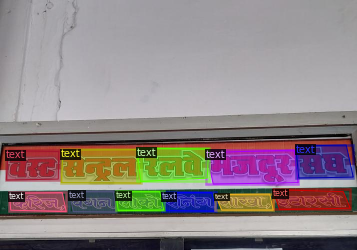

/content/real_Image_dataset_Detection/Image/42.jpg


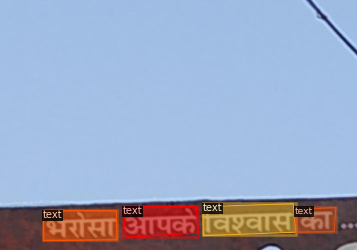

/content/real_Image_dataset_Detection/Image/173.jpg


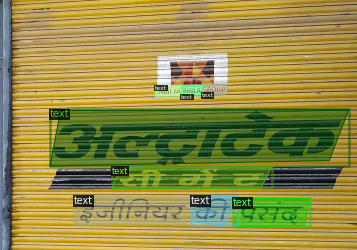

/content/real_Image_dataset_Detection/Image/13116615_1804919146396837_824128706_n.jpg


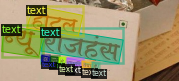

/content/real_Image_dataset_Detection/Image/119. img_9800-1.jpg


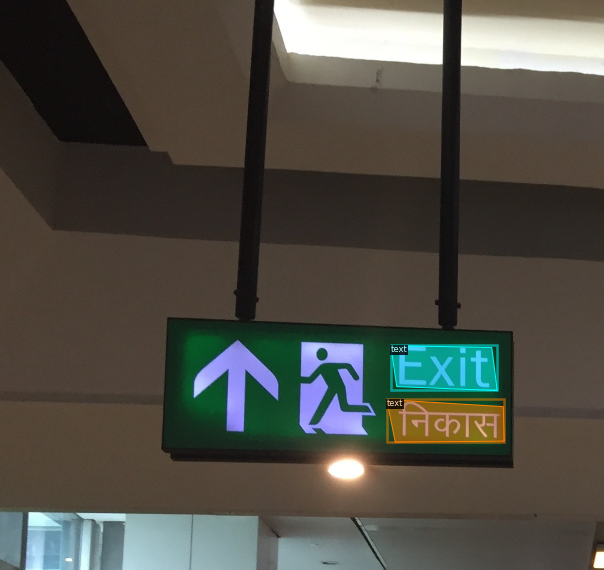

/content/real_Image_dataset_Detection/Image/261.jpg


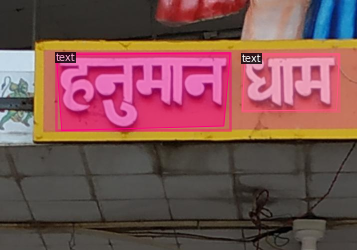

/content/real_Image_dataset_Detection/Image/76. pitampuradelhi.jpg


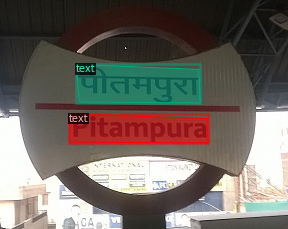

/content/real_Image_dataset_Detection/Image/296.jpg


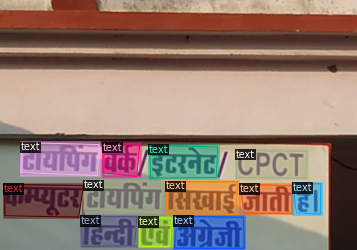

/content/real_Image_dataset_Detection/Image/228.jpg


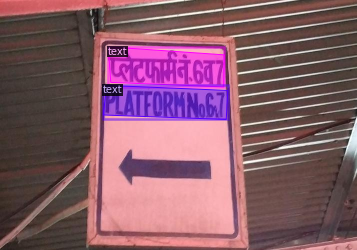

/content/real_Image_dataset_Detection/Image/260.jpg


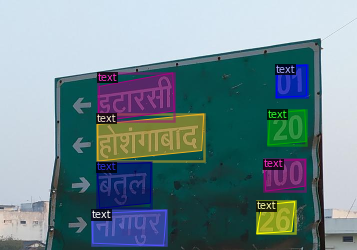

/content/real_Image_dataset_Detection/Image/152. 28177310_3e1bf624-1bdc-43fe-a8d5-52b75cd96970.jpg


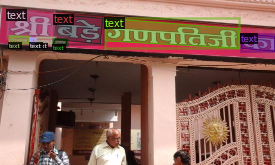

/content/real_Image_dataset_Detection/Image/316.jpg


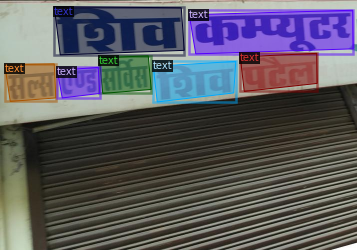

/content/real_Image_dataset_Detection/Image/170. img_4941.jpg


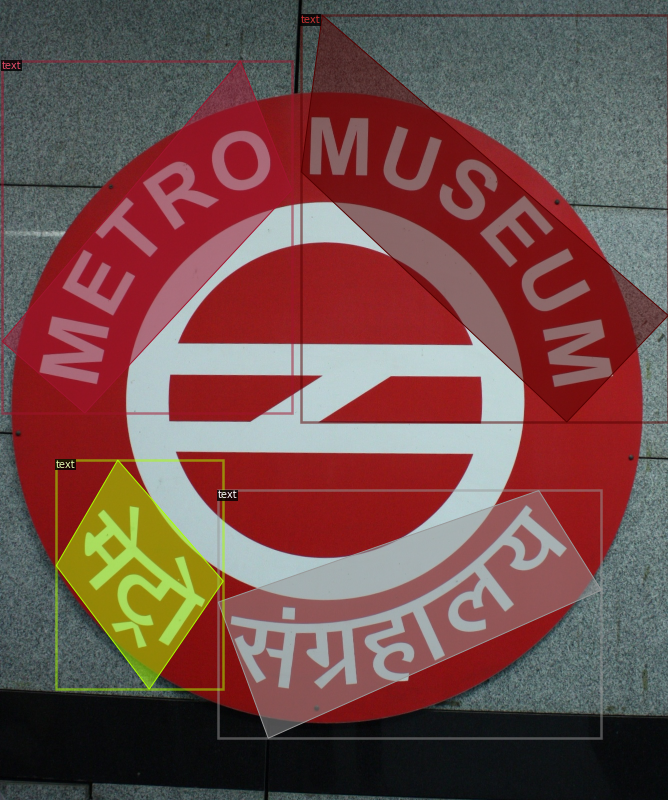

/content/real_Image_dataset_Detection/Image/245.jpg


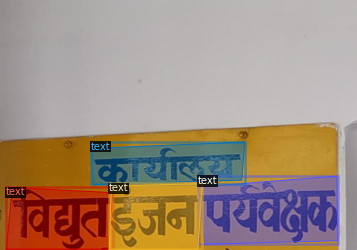

In [ ]:
data = test_dict
for d in random.sample(data, 20):
    print(d['file_name'])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=text_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

/content/Synthetic Train Set - Detection & Recognition/Image/2/1683.jpg


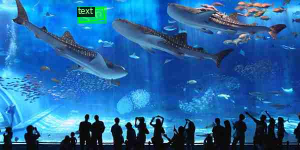

/content/Synthetic Train Set - Detection & Recognition/Image/9/4763.jpg


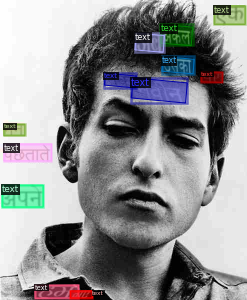

/content/Synthetic Train Set - Detection & Recognition/Image/23/966.jpg


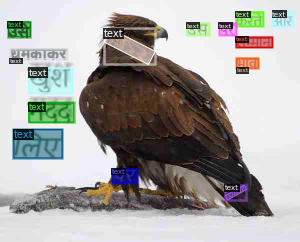

In [ ]:
data = train_dict
for d in random.sample(data, 3):
    print(d['file_name'])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=text_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("text_train",)
cfg.DATASETS.TEST = ("text_test")
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 3000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join('/content/output', "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.97   # set a custom testing threshold for this model
cfg.DATASETS.TEST = ("text_test", )
predictor = DefaultPredictor(cfg)

{'instances': Instances(num_instances=3, image_height=500, image_width=715, fields=[pred_boxes: Boxes(tensor([[422.0453, 243.5136, 636.4564, 360.6351],
        [122.8823, 241.7195, 428.7774, 369.6456],
        [171.5872, 393.3306, 378.7735, 488.8783]], device='cuda:0')), scores: tensor([0.9914, 0.9913, 0.9732], device='cuda:0'), pred_classes: tensor([0, 0, 0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, Fa

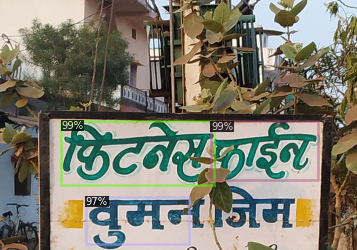

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dict = test_dict
for d in random.sample(dataset_dict, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=text_metadata, 
                   scale=0.5, 
                  #  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    print(outputs)
    instances = outputs["instances"].to("cpu")
    instances.remove('pred_masks')
    for i in instances.get_fields()['pred_boxes']:
      print(i)
    out = v.draw_instance_predictions(instances)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.modeling import build_model
model = build_model(cfg)  # returns a torch.nn.Module

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("text_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "text_test")
# print(inference_on_dataset(model, val_loader, evaluator))